In [1]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from deepymod.analysis import load_tensorboard
from natsort import natsorted
import os
import pandas as pd

In [3]:
# settings
plt.style.use('seaborn-paper')
col_width = 5.5 # neurips style column width in inches
fontsize=8
plt.rcParams.update({'font.size': fontsize})
%config InlineBackend.figure_format = 'svg'

# Single run plot

In [3]:
# loading data
df_bayes = load_tensorboard("runs_single/bayes_run_0/")
df_pinn = load_tensorboard("runs_single/pinn_run_0/")
df_mt = load_tensorboard("runs_single/multitask_run_0/")

AttributeError: 'DataFrame' object has no attribute 'loss'

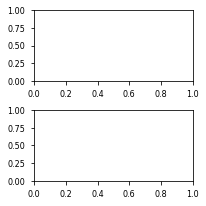

In [4]:
fig, axes = plt.subplots(nrows=2, figsize=(0.5 * col_width, 0.5 * col_width), constrained_layout=True)

ax = axes[0]
ax.plot(df_pinn.index, df_pinn.loss, label='PINN')
ax.plot(df_mt.index, df_mt.reg + df_mt.mse, label='MT')
ax.plot(df_bayes.index, df_bayes.reg + df_bayes.mse, label='BMT')

ax.ticklabel_format(axis='x', style='sci', scilimits=[0, 0])
ax.legend()
#ax.set_xlabel('Epoch')
#ax.set_ylabel('Loss')
#ax.set_xticks([])
ax.set_yscale('log')
ax.set_xlim([0, 2500])
ax.set_ylim([5e-4, 3e-1])

ax = axes[1]
ax.plot(df_mt.index, df_mt.tau, label=r'$\tau_{MT}$')
ax.plot(df_mt.index, df_mt.nu, label=r'$\beta_{MT}$')

ax.plot(df_bayes.index, df_bayes.tau, label=r'$\tau_{BMT}$', linestyle='--')
ax.plot(df_bayes.index, df_bayes.nu, label=r'$\beta_{BMT}$', linestyle='--')


ax.ticklabel_format(axis='x', style='sci', scilimits=[0, 0])
ax.legend(loc='upper right')
ax.set_xlabel('Epoch')
#ax.set_ylabel('Precision')
ax.set_yscale('log')
ax.set_xlim([0, 2500])

plt.savefig('multitask.pdf', bbox_inches='tight')

# Multple run plot

In [10]:
files = natsorted([file for file in os.listdir('runs') if file.find('bayes')==0])
dfs_bayes = [load_tensorboard(f'runs/{file}') for file in files]

In [11]:
files = natsorted([file for file in os.listdir('runs') if file.find('multitask')==0])
dfs_mt = [load_tensorboard(f'runs/{file}') for file in files]

In [12]:
files = natsorted([file for file in os.listdir('runs') if file.find('pinn')==0])
dfs_pinn = [load_tensorboard(f'runs/{file}') for file in files]

In [13]:
def mean_std(prop, df_list, log):
    """Returns mean and std and (mean - std, mean + std) of prop for all dataframes in df_list."""
    data = np.stack([prop(df) for df in df_list], axis=1)
    if log:
        data = np.log10(data)
    mean = np.mean(data, axis=1)  
    std = np.std(data, axis=1)  
    return mean, std, (mean-std, mean + std)

In [14]:
bayes_mu_std = mean_std(lambda df: df.mse + df.reg, dfs_bayes, log=True)
mt_mu_std = mean_std(lambda df: df.mse + df.reg, dfs_mt, log=True)
pinn_mu_std = mean_std(lambda df: df.mse + df.reg, dfs_pinn, log=True)

In [15]:
x_vals = dfs_bayes[0].index

In [16]:
tau_bayes = mean_std(lambda df: df.tau, dfs_bayes, log=True)
tau_mt = mean_std(lambda df: df.tau, dfs_mt, log=True)

beta_bayes = mean_std(lambda df: df.nu, dfs_bayes, log=True)
beta_mt = mean_std(lambda df: df.nu, dfs_mt, log=True)

In [17]:
fontsize = 8
plt.rcParams.update({'font.size': fontsize})

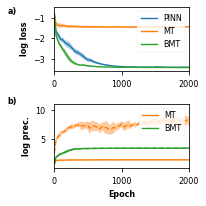

In [18]:
fig, axes = plt.subplots(nrows=2, figsize=(0.5 * col_width, 0.5 * col_width), constrained_layout=True)

ax = axes[0]
ax.plot(x_vals, pinn_mu_std[0], label="PINN")
ax.fill_between(x_vals, pinn_mu_std[2][0], pinn_mu_std[2][1], alpha=0.4)
ax.plot(x_vals, mt_mu_std[0], label='MT')
ax.fill_between(x_vals, mt_mu_std[2][0], mt_mu_std[2][1], alpha=0.4)

ax.plot(x_vals, bayes_mu_std[0], label='BMT')
ax.fill_between(x_vals, bayes_mu_std[2][0], bayes_mu_std[2][1], alpha=0.4)

ax.legend(loc='upper right')
ax.set_ylabel('log loss', fontdict={'weight':'bold', "size": fontsize})
ax.set_xlim([0, 2000])
ax.set_xticks([0, 1000, 2000])
ax.text(-700.0, -0.8, 'a)',fontdict={'weight':'bold', 'size': fontsize})


ax = axes[1]
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
ax.plot(x_vals, tau_mt[0], label='MT', color=color)
ax.fill_between(x_vals, tau_mt[2][0], tau_mt[2][1], alpha=0.4, color=color)

ax.plot(x_vals, beta_mt[0], linestyle='--', color=color)
ax.fill_between(x_vals, beta_mt[2][0], beta_mt[2][1], alpha=0.4, color=color)

color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
ax.plot(x_vals, tau_bayes[0], label='BMT', color=color)
ax.fill_between(x_vals, tau_bayes[2][0], tau_bayes[2][1], alpha=0.4, color=color)

ax.plot(x_vals, beta_bayes[0], linestyle='--', color=color)
ax.fill_between(x_vals, beta_bayes[2][0], beta_bayes[2][1], alpha=0.4, color=color)

ax.text(-700.0, 11, 'b)', fontdict={'weight':'bold', 'size': fontsize})
ax.legend(loc='upper right')
ax.set_xlabel('Epoch', fontdict={'weight':'bold', "size": fontsize})
ax.set_ylabel('log prec.',  fontdict={'weight':'bold', "size":fontsize })
ax.set_xticks([0, 1000, 2000])
ax.set_xlim([0, 2000])

plt.savefig('multitask.pdf', bbox_inches='tight', pad_inches=0)

# Plot 2.0

In [4]:
files = natsorted([file for file in os.listdir('runs') if file.find('bayes')==0])
dfs_bayes = [load_tensorboard(f'runs/{file}') for file in files]

In [5]:
files = natsorted([file for file in os.listdir('runs') if file.find('multitask')==0])
dfs_mt = [load_tensorboard(f'runs/{file}') for file in files]

In [6]:
files = natsorted([file for file in os.listdir('runs') if file.find('pinn')==0])
dfs_pinn = [load_tensorboard(f'runs/{file}') for file in files]

In [7]:
def mean_std(prop, df_list, log):
    """Returns mean and std and (mean - std, mean + std) of prop for all dataframes in df_list."""
    data = np.stack([prop(df) for df in df_list], axis=1)
    if log:
        data = np.log10(data)
    mean = np.mean(data, axis=1)  
    std = np.std(data, axis=1)  
    return mean, std, (mean-std, mean + std)

In [8]:
bayes_mse = mean_std(lambda df: df.mse, dfs_bayes, log=True)
mt_mse = mean_std(lambda df: df.mse, dfs_mt, log=True)
pinn_mse = mean_std(lambda df: df.mse, dfs_pinn, log=True)

bayes_reg = mean_std(lambda df: df.reg, dfs_bayes, log=True)
mt_reg = mean_std(lambda df: df.reg, dfs_mt, log=True)
pinn_reg = mean_std(lambda df: df.reg, dfs_pinn, log=True)

In [9]:
x_vals = dfs_bayes[0].index

In [10]:
tau_bayes = mean_std(lambda df: df.tau, dfs_bayes, log=True)
tau_mt = mean_std(lambda df: df.tau, dfs_mt, log=True)

beta_bayes = mean_std(lambda df: df.nu, dfs_bayes, log=True)
beta_mt = mean_std(lambda df: df.nu, dfs_mt, log=True)

In [11]:
fontsize = 8
plt.rcParams.update({'font.size': fontsize})

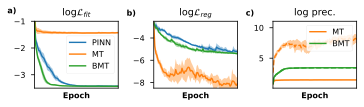

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(0.9 * col_width, 0.25 * col_width), constrained_layout=True)

ax = axes[0]
ax.plot(x_vals, pinn_mse[0], label="PINN")
ax.fill_between(x_vals, pinn_mse[2][0], pinn_mse[2][1], alpha=0.4)
ax.plot(x_vals, mt_mse[0], label='MT')
ax.fill_between(x_vals, mt_mse[2][0], mt_mse[2][1], alpha=0.4)
ax.plot(x_vals, bayes_mse[0], label='BMT')
ax.fill_between(x_vals, bayes_mse[2][0], bayes_mse[2][1], alpha=0.4)

ax.legend()
#ax.set_ylabel('log loss', fontdict={'weight':'bold', "size": fontsize})
ax.set_xlim([0, 2000])
#ax.set_xticks([0, 1000, 2000])
ax.set_ylim([-3.5, -1])
ax.text(-650.0, -0.7, 'a)',fontdict={'weight':'bold', 'size': fontsize})
ax.set_xticks([])
ax.set_xlabel('Epoch', fontdict={'weight':'bold', "size": fontsize})
ax.set_title(r'$\log \mathcal{L}_{fit}$')

ax = axes[1]
ax.plot(x_vals, pinn_reg[0], label="PINN")
ax.fill_between(x_vals, pinn_reg[2][0], pinn_reg[2][1], alpha=0.4)
ax.plot(x_vals, mt_reg[0], label='MT')
ax.fill_between(x_vals, mt_reg[2][0], mt_reg[2][1], alpha=0.4)
ax.plot(x_vals, bayes_reg[0], label='BMT')
ax.fill_between(x_vals, bayes_reg[2][0], bayes_reg[2][1], alpha=0.4)

#ax.legend(loc='upper right')
ax.set_title(r'$\log \mathcal{L}_{reg}$')
ax.set_xlim([0, 2000])
#ax.set_xticks([0, 1000, 2000])
ax.text(-650.0, -2, 'b)',fontdict={'weight':'bold', 'size': fontsize})
ax.set_ylim([-8.5, -2.5])
ax.set_xticks([])
ax.set_xlabel('Epoch', fontdict={'weight':'bold', "size": fontsize})


ax = axes[2]
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
ax.plot(x_vals, tau_mt[0], label='MT', color=color)
ax.fill_between(x_vals, tau_mt[2][0], tau_mt[2][1], alpha=0.4, color=color)

ax.plot(x_vals, beta_mt[0], linestyle='--', color=color)
ax.fill_between(x_vals, beta_mt[2][0], beta_mt[2][1], alpha=0.4, color=color)

color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
ax.plot(x_vals, tau_bayes[0], label='BMT', color=color)
ax.fill_between(x_vals, tau_bayes[2][0], tau_bayes[2][1], alpha=0.4, color=color)

ax.plot(x_vals, beta_bayes[0], linestyle='--', color=color)
ax.fill_between(x_vals, beta_bayes[2][0], beta_bayes[2][1], alpha=0.4, color=color)

ax.text(-650.0, 12, 'c)', fontdict={'weight':'bold', 'size': fontsize})
ax.legend(loc='upper right')
ax.set_xticks([])
ax.set_xlabel('Epoch', fontdict={'weight':'bold', "size": fontsize})

ax.set_title('log prec.')
#ax.set_xticks([0, 1000, 2000])

ax.set_xlim([0, 2000])

plt.savefig('multitask.pdf', bbox_inches='tight', pad_inches=0)

# Plot 3.0

In [2]:
files = natsorted([file for file in os.listdir('runs') if file.find('bayes')==0])
dfs_bayes = [load_tensorboard(f'runs/{file}') for file in files]

In [3]:
files = natsorted([file for file in os.listdir('runs') if file.find('multitask')==0])
dfs_mt = [load_tensorboard(f'runs/{file}') for file in files]

In [4]:
files = natsorted([file for file in os.listdir('runs') if file.find('pinn')==0])
dfs_pinn = [load_tensorboard(f'runs/{file}') for file in files]

In [17]:
x_vals = dfs_bayes[0].index

In [18]:
def mean_std(prop, df_list, log):
    """Returns mean and std and (mean - std, mean + std) of prop for all dataframes in df_list."""
    data = np.stack([prop(df) for df in df_list], axis=1)
    if log:
        data = np.log10(data)
    mean = np.mean(data, axis=1)  
    std = np.std(data, axis=1)  
    return mean, std, (mean-std, mean + std)

In [19]:
bayes_mse = mean_std(lambda df: df.mse, dfs_bayes, log=True)
mt_mse = mean_std(lambda df: df.mse, dfs_mt, log=True)
pinn_mse = mean_std(lambda df: df.mse, dfs_pinn, log=True)

bayes_reg = mean_std(lambda df: df.reg, dfs_bayes, log=True)
mt_reg = mean_std(lambda df: df.reg, dfs_mt, log=True)
pinn_reg = mean_std(lambda df: df.reg, dfs_pinn, log=True)

In [20]:
epoch = dfs_bayes[0].index

In [21]:
tau_bayes = mean_std(lambda df: df.tau, dfs_bayes, log=True)
tau_mt = mean_std(lambda df: df.tau, dfs_mt, log=True)

beta_bayes = mean_std(lambda df: df.nu, dfs_bayes, log=True)
beta_mt = mean_std(lambda df: df.nu, dfs_mt, log=True)

In [22]:
fontsize = 7
plt.rcParams.update({'font.size': fontsize})

In [23]:
# settings
plt.style.use('seaborn-paper')
col_width = 5.5 # neurips style column width in inches
%config InlineBackend.figure_format = 'svg'

label_size = 8

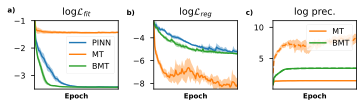

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(0.9 * col_width, 0.25 * col_width), constrained_layout=True)

ax = axes[0]
ax.plot(x_vals, pinn_mse[0], label="PINN")
ax.fill_between(x_vals, pinn_mse[2][0], pinn_mse[2][1], alpha=0.4)
ax.plot(x_vals, mt_mse[0], label='MT')
ax.fill_between(x_vals, mt_mse[2][0], mt_mse[2][1], alpha=0.4)
ax.plot(x_vals, bayes_mse[0], label='BMT')
ax.fill_between(x_vals, bayes_mse[2][0], bayes_mse[2][1], alpha=0.4)

ax.legend()
#ax.set_ylabel('log loss', fontdict={'weight':'bold', "size": fontsize})
ax.set_xlim([0, 2000])
#ax.set_xticks([0, 1000, 2000])
ax.set_ylim([-3.5, -1])
ax.text(-650.0, -0.7, 'a)',fontdict={'weight':'bold', 'size': fontsize})
ax.set_xticks([])
ax.set_xlabel('Epoch', fontdict={'weight':'bold', "size": fontsize})
ax.set_title(r'$\log \mathcal{L}_{fit}$')

ax = axes[1]
ax.plot(x_vals, pinn_reg[0], label="PINN")
ax.fill_between(x_vals, pinn_reg[2][0], pinn_reg[2][1], alpha=0.4)
ax.plot(x_vals, mt_reg[0], label='MT')
ax.fill_between(x_vals, mt_reg[2][0], mt_reg[2][1], alpha=0.4)
ax.plot(x_vals, bayes_reg[0], label='BMT')
ax.fill_between(x_vals, bayes_reg[2][0], bayes_reg[2][1], alpha=0.4)

#ax.legend(loc='upper right')
ax.set_title(r'$\log \mathcal{L}_{reg}$')
ax.set_xlim([0, 2000])
#ax.set_xticks([0, 1000, 2000])
ax.text(-650.0, -2, 'b)',fontdict={'weight':'bold', 'size': fontsize})
ax.set_ylim([-8.5, -2.5])
ax.set_xticks([])
ax.set_xlabel('Epoch', fontdict={'weight':'bold', "size": fontsize})


ax = axes[2]
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
ax.plot(x_vals, tau_mt[0], label='MT', color=color)
ax.fill_between(x_vals, tau_mt[2][0], tau_mt[2][1], alpha=0.4, color=color)

ax.plot(x_vals, beta_mt[0], linestyle='--', color=color)
ax.fill_between(x_vals, beta_mt[2][0], beta_mt[2][1], alpha=0.4, color=color)

color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
ax.plot(x_vals, tau_bayes[0], label='BMT', color=color)
ax.fill_between(x_vals, tau_bayes[2][0], tau_bayes[2][1], alpha=0.1, color=color)

ax.plot(x_vals, beta_bayes[0], linestyle='--', color=color)
ax.fill_between(x_vals, beta_bayes[2][0], beta_bayes[2][1], alpha=0.1, color=color)

ax.text(-650.0, 12, 'c)', fontdict={'weight':'bold', 'size': fontsize})
ax.legend(loc='upper right')
ax.set_xticks([])
ax.set_xlabel('Epoch', fontdict={'weight':'bold', "size": fontsize})

ax.set_title('log prec.')
#ax.set_xticks([0, 1000, 2000])

ax.set_xlim([0, 2000])

plt.savefig('multitask.pdf', bbox_inches='tight', pad_inches=0)

In [25]:
bayes_mse = mean_std(lambda df: df.mse, dfs_bayes, log=False)
mt_mse = mean_std(lambda df: df.mse, dfs_mt, log=False)
pinn_mse = mean_std(lambda df: df.mse, dfs_pinn, log=False)

bayes_reg = mean_std(lambda df: df.reg, dfs_bayes, log=False)
mt_reg = mean_std(lambda df: df.reg, dfs_mt, log=False)
pinn_reg = mean_std(lambda df: df.reg, dfs_pinn, log=False)

In [26]:
tau_bayes = mean_std(lambda df: df.tau, dfs_bayes, log=False)
tau_mt = mean_std(lambda df: df.tau, dfs_mt, log=False)

beta_bayes = mean_std(lambda df: df.nu, dfs_bayes, log=False)
beta_mt = mean_std(lambda df: df.nu, dfs_mt, log=False)

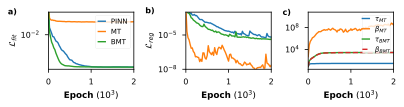

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(1.0 * col_width, 0.25 * col_width), constrained_layout=True)

ax = axes[0]
ax.plot(x_vals, pinn_mse[0], label="PINN")
ax.plot(x_vals, mt_mse[0], label='MT')
ax.plot(x_vals, bayes_mse[0], label='BMT')

ax.legend(fontsize=7, loc='upper right', handlelength=1)
ax.set_xlim([0, 2000])
ax.set_ylim([3e-4, 1e-1])
ax.set_xlabel(r'$\mathbf{Epoch}$ ($10^3$)')
ax.set_ylabel(r'$\mathcal{L}_{fit}$')
ax.set_yscale('log')
ax.set_xticks([0, 1000, 2000])
ax.set_xticklabels([0, 1, 2])
ax.text(-950.0, 8e-2, 'a)',fontdict={'weight':'bold', 'size': label_size})

ax = axes[1]
ax.plot(x_vals, pinn_reg[0], label="PINN")
#ax.fill_between(x_vals, pinn_reg[2][0], pinn_reg[2][1], alpha=0.4)
ax.plot(x_vals, mt_reg[0], label='MT')
#ax.fill_between(x_vals, mt_reg[2][0], mt_reg[2][1], alpha=0.4)
ax.plot(x_vals, bayes_reg[0], label='BMT')
#ax.fill_between(x_vals, bayes_reg[2][0], bayes_reg[2][1], alpha=0.4)

#ax.legend(loc='upper right')
ax.set_ylabel(r'$\mathcal{L}_{reg}$')
ax.set_xlim([0, 2000])
#ax.set_xticks([0, 1000, 2000])
ax.text(-950.0, 8e-4, 'b)',fontdict={'weight':'bold', 'size': label_size})
ax.set_ylim([1e-8, 1e-3])
#ax.set_xticks([])
ax.set_xlabel(r'$\mathbf{Epoch}$ ($10^3$)')
ax.set_yscale('log')
ax.set_xticks([0, 1000, 2000])
ax.set_xticklabels([0, 1, 2])


ax = axes[2]
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
ax.plot(x_vals, tau_mt[0], label=r'$\tau_{MT}$')
#ax.fill_between(x_vals, tau_mt[2][0], tau_mt[2][1], alpha=0.4, color=color)

ax.plot(x_vals, beta_mt[0], label=r'$\beta_{MT}$')
#ax.fill_between(x_vals, beta_mt[2][0], beta_mt[2][1], alpha=0.4, color=color)

color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
ax.plot(x_vals, tau_bayes[0], label=r'$\tau_{BMT}$')
#ax.fill_between(x_vals, tau_bayes[2][0], tau_bayes[2][1], alpha=0.1, color=color)

ax.plot(x_vals, beta_bayes[0], '--', label=r'$\beta_{BMT}$')
#ax.fill_between(x_vals, beta_bayes[2][0], beta_bayes[2][1], alpha=0.1, color=color)

ax.text(-600.0, 2e10, 'c)', fontdict={'weight':'bold', 'size': label_size})
ax.legend(fontsize=7, ncol=1, handlelength=1, loc='upper right', borderpad=0.0)
ax.set_xlabel(r'$\mathbf{Epoch}$ ($10^3$)')
ax.set_yscale('log')
ax.set_xticks([0, 1000, 2000])
ax.set_xticklabels([0, 1, 2])
#ax.set_title('log prec.')
#ax.set_xticks([0, 1000, 2000])

ax.set_xlim([0, 2000])

plt.savefig('multitask.pdf', bbox_inches='tight', pad_inches=0)